### Load the Data Files

In [7]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
STATS_DIR = "prometheus-stats"

def load_and_process_data(filepath, experiment_name, value_upper_bound=10000):
    """
    Loads ANY data CSV, cleans it, and isolates the most recent experiment run.
    """
    if not os.path.exists(filepath):
        print(f"ERROR: File not found at {filepath}. Skipping.")
        return pd.DataFrame()

    df = pd.read_csv(filepath)
    df['experiment'] = experiment_name
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Clean the data
    df.dropna(subset=['value'], inplace=True)
    df = df[df['value'] < value_upper_bound]
    df = df.sort_values('timestamp')
    
    # Isolate the most recent run by finding large time gaps
    df['time_diff'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
    new_experiment_start_index = df[df['time_diff'] > 600].index
    if not new_experiment_start_index.empty:
        last_start_index = new_experiment_start_index[-1]
        df = df.loc[last_start_index:]
        
    return df

# --- Load and clean ALL data files for the latest run ---
print("--- Processing Latency Data ---")
df_latency_ai = load_and_process_data(os.path.join(STATS_DIR, 'ai_run_p99_latency_per_pod_ms.csv'), 'AI-Controlled')
df_latency_base = load_and_process_data(os.path.join(STATS_DIR, 'baseline_p99_latency_per_pod_ms.csv'), 'Baseline')

print("\n--- Processing RPS Data ---")
# For RPS, the upper bound can be much higher, so we set it higher.
df_rps_ai = load_and_process_data(os.path.join(STATS_DIR, 'ai_run_rps_per_pod.csv'), 'AI-Controlled', value_upper_bound=50000)
df_rps_base = load_and_process_data(os.path.join(STATS_DIR, 'baseline_rps_per_pod.csv'), 'Baseline', value_upper_bound=50000)

print("\nAll dataframes (df_latency_*, df_rps_*) are now loaded and ready.")

--- Processing Latency Data ---

--- Processing RPS Data ---

All dataframes (df_latency_*, df_rps_*) are now loaded and ready.


### Latency Comparison

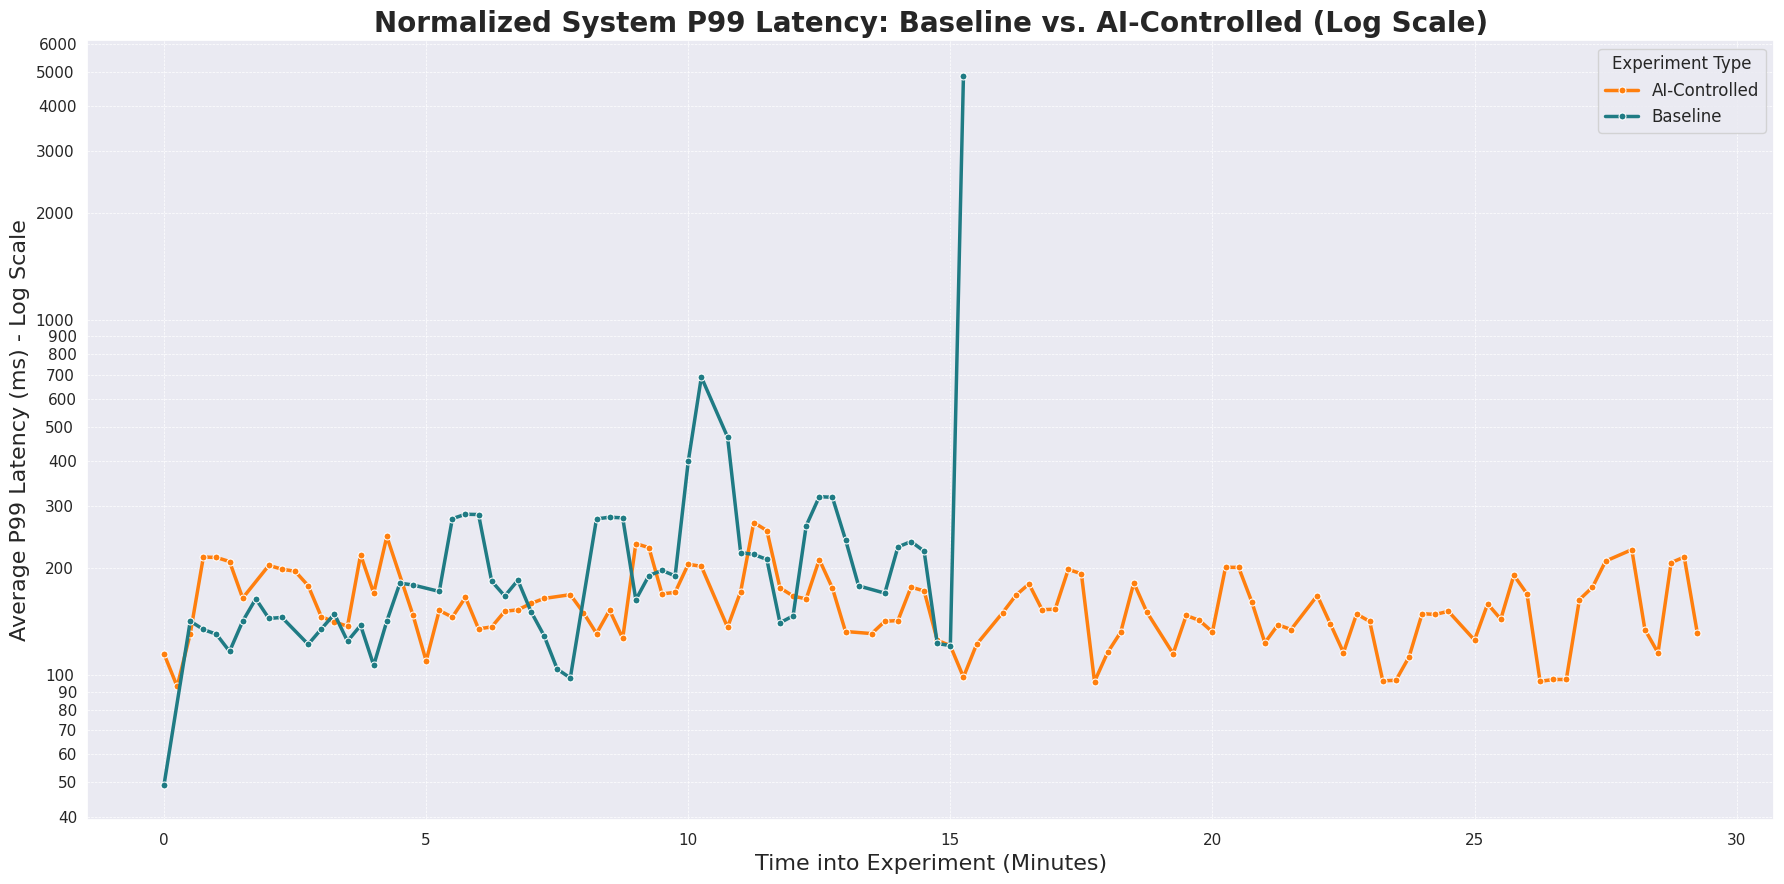

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker # Import the ticker library for formatting

# --- Combine the clean latency data ---
combined_clean_latency = pd.concat([df_latency_base, df_latency_ai])

# --- Aggregate and Normalize Latency Data ---
system_latency_avg = combined_clean_latency.groupby(['experiment', pd.Grouper(key='timestamp', freq='15s')])['value'].mean().reset_index()
start_times = system_latency_avg.groupby('experiment')['timestamp'].transform('min')
system_latency_avg['elapsed_minutes'] = (system_latency_avg['timestamp'] - start_times).dt.total_seconds() / 60

# --- Plot the Latency Graph ---
# Get the axis object to manipulate it directly
fig, ax = plt.subplots(figsize=(18, 9))

sns.lineplot(
    data=system_latency_avg, 
    x='elapsed_minutes', 
    y='value', 
    hue='experiment', 
    palette=['#ff7f0e', '#1f7b84'], 
    marker='o', 
    markersize=5,
    linewidth=2.5,
    ax=ax  # Tell seaborn to use our axis object
)

# --- NEW: TAKE MANUAL CONTROL OF THE Y-AXIS ---
# 1. Set the scale to logarithmic
ax.set_yscale('log')

# 2. Force the labels to be normal numbers (e.g., "500" instead of "10^2.7")
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())

# 3. Set specific tick marks to guide the eye. You can customize this list.
ax.set_yticks([100, 200, 300, 500, 700, 1000, 2000, 3000, 5000])
# --- END OF NEW CODE ---


# --- Add Titles and Labels ---
ax.set_title('Normalized System P99 Latency: Baseline vs. AI-Controlled (Log Scale)', fontsize=20, weight='bold')
ax.set_xlabel('Time into Experiment (Minutes)', fontsize=16)
ax.set_ylabel('Average P99 Latency (ms) - Log Scale', fontsize=16)
ax.legend(title='Experiment Type', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(STATS_DIR, 'comparison_latency_graph_log_scale_final.png'))
plt.show()

###  Compare Summary Statistics

In [9]:
# --- Calculate Summary Statistics from the Cleaned Dataframes ---

# Baseline Summary
avg_latency_base = df_latency_base['value'].mean()
avg_rps_base = df_rps_base['value'].mean()

# AI Run Summary
avg_latency_ai = df_latency_ai['value'].mean()
avg_rps_ai = df_rps_ai['value'].mean()

# Calculate Improvements
try:
    latency_improvement = ((avg_latency_base - avg_latency_ai) / avg_latency_base) * 100
except (ZeroDivisionError, ValueError):
    latency_improvement = np.nan

try:
    rps_improvement = ((avg_rps_ai - avg_rps_base) / avg_rps_base) * 100
except (ZeroDivisionError, ValueError):
    rps_improvement = np.nan

# --- Print the Final Report ---
print("="*60)
print("          PERFORMANCE COMPARISON SUMMARY (Latest Run)")
print("="*60)
print(f"{'Metric':<25} | {'Baseline':>15} | {'AI-Controlled':>15}")
print("-"*60)
print(f"{'Avg P99 Latency (ms)':<25} | {avg_latency_base:>15.2f} | {avg_latency_ai:>15.2f}")
print(f"{'Avg Requests Per Second (RPS)':<25} | {avg_rps_base:>15.2f} | {avg_rps_ai:>15.2f}")
print("-"*60)
print(f"Latency Improvement: {latency_improvement:+.2f}%")
print(f"RPS Improvement:     {rps_improvement:+.2f}%")
print("="*60)

          PERFORMANCE COMPARISON SUMMARY (Latest Run)
Metric                    |        Baseline |   AI-Controlled
------------------------------------------------------------
Avg P99 Latency (ms)      |          283.08 |          159.19
Avg Requests Per Second (RPS) |            6.33 |            9.84
------------------------------------------------------------
Latency Improvement: +43.77%
RPS Improvement:     +55.37%
